In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import random
import itertools
import torch
from scipy.stats import multivariate_normal

random_seed = 42 # for reproductibility
## set cuda device

# Check if a CUDA GPU is available
if torch.cuda.is_available():
    # Set the default device to the first available GPU
    device = torch.device("cuda")
else:
    # If no GPU is available, use the CPU
    device = torch.device("cpu")

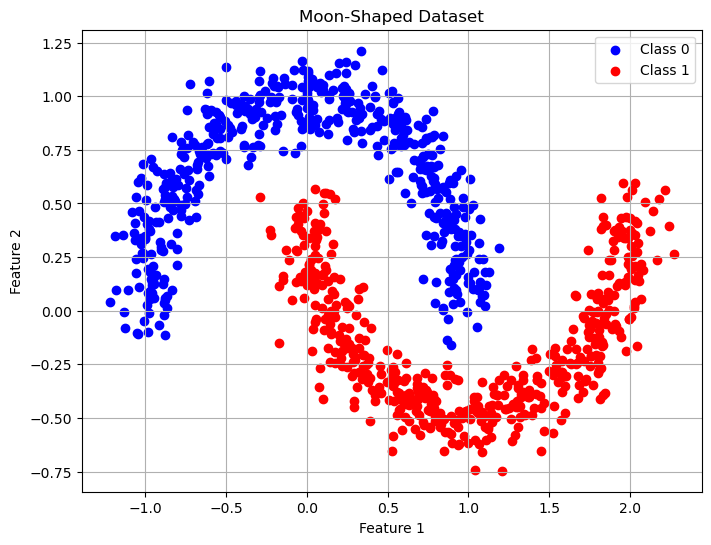

In [3]:
# Create a moon-shaped dataset with 100 samples
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)

# X contains the data points, and y contains their corresponding labels (0 or 1)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='Class 1')

plt.title("Moon-Shaped Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

plt.show()

Build 2D-Histogram

<div style="color: green; font-weight:
bold">histogram is build as a class not as a function in the sample solution, but implementation is essentially the same: There are n bins in every dimension (so we fit the data into a regular grid in R^2) and fill the bins. Building and filling of bins use nested for loops which make the computation very slow, instead just saving x_min, x_max and the length of steps in x direction(etc.) and only computating edges of bins when needed is faster.</div> 

In [17]:
#build indicatorfunction on half-closed cubes
def indicator(x, y, a, b, c, d):
    # a1,b1: edges of the first intervall
    # a2,b2: edges of the second intervall

    if a<=x and x<b and c<=y and y<d:
        return 1
    else:
        return 0        

def histogram2d(data, n_edges=10):
    # we define bins as cubes of a regular grid in R^2
    # n_edges are the number of different edges per dimensions of the cubes

    x_min = min(data[:,0])
    x_max = max(data[:,0])
    y_min = min(data[:,1])
    y_max = max(data[:,1])
    n_samples = data.shape[0]

    #get length of steps in each dimension
    h1 = abs(x_max-x_min) / n_edges
    h2 = abs(y_max-y_min) / n_edges
    
    #build qubes
    edges = np.zeros((n_edges, n_edges, 4))
    for i in range(n_edges):
        for j in range(n_edges):
            edges[i,j,0] = x_min + i*h1     #lower x edge
            edges[i,j,1] = x_min + (i+1)*h1     #upper x edge
            edges[i,j,2] = y_min + j*h2     #lower y edge
            edges[i,j,3] = y_min + (j+1)*h2     #upper y edge

    
    #fill bins
    bins = np.zeros((n_edges,n_edges),dtype=float)
    for i in range(n_samples):
        for j in range(n_edges):
            for k in range(n_edges):     
                if edges[j,k,0]<=data[i,0] and data[i,0]<edges[j,k,1] and edges[j,k,2]<=data[i,1] and data[i,1]<edges[j,k,3]:
                    bins[j,k] += 1
                    break

    #build density
    def density(x,y):
        sum = 0
        for i in range(n_edges):
            for i in range(n_edges):
                sum += indicator(x, y, edges[i,j,0], edges[i,j,1], edges[i,j,2], edges[i,j,3]) * bins[i,j] / n_samples*h1*h2
        
        return sum    

    return density, bins, edges

density, bins, edges = histogram2d(X, 10)
bins

array([[ 0.,  0.,  0., 12., 23., 26., 15.,  5.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  3.,  4., 26., 32., 16.,  2.],
       [ 0.,  0.,  0.,  1.,  1.,  2.,  1.,  9., 39.,  9.],
       [ 0.,  2.,  6., 15., 32., 24., 13.,  3., 28., 22.],
       [ 1.,  9., 31., 19.,  5.,  0.,  1.,  6., 36., 11.],
       [ 7., 49., 16.,  5.,  2.,  9., 25., 36., 21.,  1.],
       [14., 34.,  7.,  4., 28., 23., 13.,  2.,  0.,  0.],
       [ 5., 30., 24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  8., 31., 31., 13., 10.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  7., 16., 21., 11.,  0.,  0.,  0.]])

Sample from Model

<div style="color: green; font-weight:
bold">Same as sample solution: randomly pick a bin (with weighted probabilities) and sample two uniform-distribution on the corresponding x,y intervalls</div> 

In [5]:
def sampling_histogram2d(N, edges, bins):

    qubes = list(itertools.product(range(bins.shape[0]), range(bins.shape[1])))
    estim_qube = random.choices(qubes, weights = bins.flatten(), k = N)     #randomly choose bin_ij to generate data 

    sample = np.zeros((N,2))
    for i in range(N):
        sample[i,0] = random.uniform(edges[estim_qube[i][0],estim_qube[i][1],0], edges[estim_qube[i][0],estim_qube[i][1],1])
        sample[i,1] = random.uniform(edges[estim_qube[i][0],estim_qube[i][1],2], edges[estim_qube[i][0],estim_qube[i][1],3])

    return sample

estim_sample = sampling_histogram2d(1000, edges, bins) 

Plot the generated Data

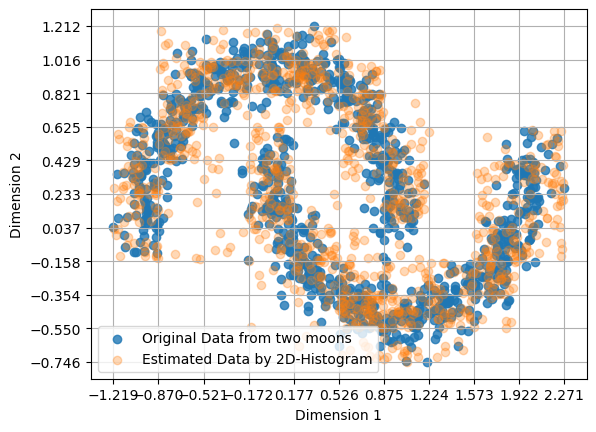

In [6]:
x_intervall = np.unique([edges[:,0,0],edges[:,0,1]])
y_intervall = np.unique([edges[0,:,2],edges[0,:,3]])

def plot_estimated_real_two_moons(data,estimated_data):
    # Plot the original data and estimated data
    plt.scatter(data[:, 0], data[:, 1], label="Original Data from two moons", alpha=0.8)
    plt.scatter(estimated_data[:,0], estimated_data[:, 1], label="Estimated Data by 2D-Histogram", alpha=0.3)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.xticks(x_intervall)
    plt.yticks(y_intervall)
    plt.grid()
    plt.show()

plot_estimated_real_two_moons(X, estim_sample)

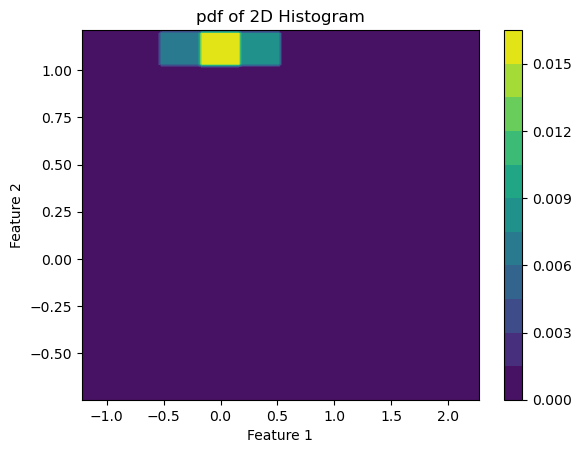

In [28]:
# Generate a grid of points for the contour plot
x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                   np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
grid = np.dstack((x, y))

#Evaluate the PDF at each point in the grid
values = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        values[i,j] = density(grid[i,j,0],grid[i,j,1])

# Create a contour plot
plt.contourf(x, y, values, levels=10, cmap='viridis')
#plt.scatter(X[:, 0], X[:, 1], color='red', marker='o', label='Data Points')

# Set labels and a legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('pdf of 2D Histogram')
#plt.legend()

# Show the plot
plt.colorbar()
plt.show()

<div style="color: green; font-weight:
bold">Visualization of pdf obviosly does not work, but since generating new data is working either the pdf itself is defined wrong or we give the wrong arguments to the plot function</div> 

Accuracy of our Model

In [ ]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"

        source: https://www.onurtunali.com/ml/2019/03/08/maximum-mean-discrepancy-in-machine-learning.html
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)

    if kernel == 'squared_exp':
      bandwidth_range = [0.2, 0.5, 0.9, 1.3]
      for a in bandwidth_range:
        XX += torch.exp(-0.5 * dxx / (a**2))
        YY += torch.exp(-0.5 * dyy / (a**2))
        XY += torch.exp(-0.5 * dxy / (a**2))


    if kernel == "inverse_multi_quadratic":
      bandwidth_range = [0.2, 0.5, 0.9, 1.3]
      for a in bandwidth_range:
          XX += 1.0 / (1.0 + a**2 * dxx)
          YY += 1.0 / (1.0 + a**2 * dyy)
          XY += 1.0 / (1.0 + a**2 * dxy)




    return torch.mean(XX + YY - 2. * XY)

result1 = MMD(torch.tensor(X), torch.tensor(estim_sample), kernel='squared_exp')
result2 = MMD(torch.tensor(X), torch.tensor(estim_sample), kernel="inverse_multi_quadratic")
print(f"MMD with squared exponential is {result1.item()}")
print(f"MMD with inverse multi quadratic is {result2.item()}")

MMD with squared exponential is 0.003793262643739581
MMD with inverse multi quadratic is 0.0011135461973026395


Influence of the number of bins on accuracy

<div style="color: green; font-weight:
bold">We evaluate MMD for every bin size from 1 to 80, while sample solution only evaluates MMD for the given bin sizes 10,20,30,40,50</div> 

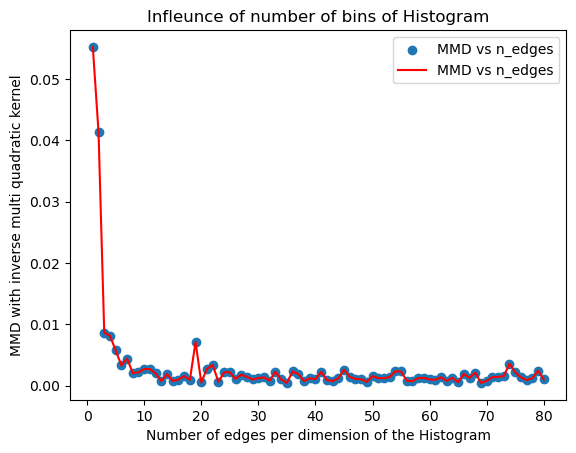

In [ ]:
n_edges_max = 80
MMD_hist = []

for i in range(n_edges_max):
    density, bins, edges = histogram2d(X, i+1)
    estim_sample = sampling_histogram2d(1000, edges, bins)
    result = MMD(torch.tensor(X), torch.tensor(estim_sample), kernel="inverse_multi_quadratic")
    MMD_hist += [(i+1,result.item())]

# Create a scatter plot
plt.scatter([x[0] for x in MMD_hist], [x[1] for x in MMD_hist], label="MMD vs n_edges")
plt.plot([x[0] for x in MMD_hist], [x[1] for x in MMD_hist], label="MMD vs n_edges",color='red')

# Add labels and a legend
plt.xlabel("Number of edges per dimension of the Histogram")
plt.ylabel("MMD with inverse multi quadratic kernel")
plt.legend()

# Display the plot
plt.title('Infleunce of number of bins of Histogram')
plt.show()

Conclusion: Increasing the number of edges per dimension significantly increases the accuracy of the model up to 15 edges (i.e. 15^2=225 bins in total), increasing the number of bins further has less of an impact on our model.